In [8]:
import numpy as np
import matplotlib.pyplot as plt
import utilities
import pyomo as pyo
from multiprocessing import Process, Value
import time, os


# Karmbandit problem

In [2]:
class karmbandit:
    """This is the k arm bandit problem

    Attributes:
        d: number of arms
        distribution (str): distribution of rewards
        params (array): parameters of the distribution, the line i contain the parameters of the distribution of the arm i
        best_arm (int): index of the best arm
    """

    def __init__(self, d, distribution, params):
        """Init the k arm bandit problem

        Args:
            d (int): number of arms
            distribution (str): distribution of rewards
            params (array): parameters of the distribution, the line i contain the parameters of the distribution of the arm i
        """

        self.d = d
        self.distribution = distribution
        self.params = params
        self.name = "karmbandit"
        if distribution == 'bernoulli':
            self.mus = params
            self.sigmas = 1/2*np.ones(d)
        if distribution == 'gaussian':
            self.mus = params[...,0]
            self.sigmas = params[...,1]
        
        self.best_arm = np.argmax(self.mus)
        self.mustar = self.mus[self.best_arm]
        self.shape = self.mus.shape
        sorted = np.sort(self.mus)
        self.Deltamin = sorted[-1] - sorted[-2]

    def pull(self):
        """Pull the arms
        
        Returns:
            reward (float): reward of the arms
        """

        if self.distribution == 'bernoulli':
            return np.random.binomial(1,self.mus)
        if self.distribution == 'gaussian':
            return np.random.normal(self.mus, self.sigmas)

class karmpolicy:
    """This is the k arm bandit policy

    Attributes:
        d: number of armsArgs:
            index (int): index of the arm to pull
        self.muhat (array): empiric mean of the arms
        t (int): time step
        w (array): number of time an arm is played
        regrets (list) : regret at each time step
        policy (str): policy to use
        params (array): parameters of the policy
    """

    def __init__(self, karmbandit, policy, algoparams = {"bonus": 1}, prior = "uniform"):
        """Init the k arm bandit policy

        Args:
            d (int): number of arms
            policy (str): policy to use
            algoparams (array): parameters of the policy, c for ucb, epsilon for epsilon-greedy, param of the prior for thompson sampling
            prior (str): by default it is the uniform prior
        """
        # get the parameters of the k arm bandit problem
        self.karmbandit = karmbandit
        self.d = karmbandit.d
        self.bestarm = karmbandit.best_arm
        self.mus = karmbandit.mus
        self.sigmas = karmbandit.sigmas
        self.distribution = karmbandit.distribution
        self.prior  = prior
        self.shape = self.mus.shape
        self.mustar = karmbandit.mustar
        

        # store in the class the policy and the initial parameters
        self.policy = policy
        self.algoparams = algoparams.copy()

        # initialise the paramater of the algorithm
        self.reset()
    
    def reset(self):
                # initialise the paramater of the algorithm
        self.regrets = []
        self.muhats = np.zeros(self.d)
        # small hack to avoid division by 0 before the arm is played for the first time
        self.t = 1
        self.w = np.ones(self.shape) * 10**(-8)

        if self.policy == 'epsilon-greedy' or self.policy == 'explore-commit':
            self.explore = self.algoparams["explore"]
        if self.policy == 'ucb':
            self.c = self.algoparams["c"]
        if self.policy == 'thompson-sampling':
            self.bonus = self.algoparams["bonus"]
            # self.lambd = self.algoparams["lambda"] will be added later
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    self.alphas = self.algoparams["prior"][...,0].copy()
                    self.betas = self.algoparams["prior"][...,1].copy()
                if self.prior == "uniform":
                    self.alphas = np.ones(self.shape)
                    self.betas = np.ones(self.shape)
                if self.prior == "gaussian":
                    # In the case of a gaussian prior for bernoulli distribution we assume that the prior is uniform on R
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.muhats = np.ones(self.shape)/2
                    self.sigmapost = 10**8 * np.ones(self.shape)
                if self.prior == "gaussian":
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.muhats = np.ones(self.shape)/2
                    self.sigmapost = 10**8 * np.ones(self.shape)
            if self.distribution == 'gaussian':
                if self.prior == "gaussian":
                    self.muhats = self.algoparams["prior"][...,0].copy()
                    self.sigmapost = self.algoparams["prior"][...,1].copy()
                if self.prior == "uniform":
                    self.muhats = np.zeros(self.shape)
                    self.sigmapost = 10**8 * np.ones(self.shape)

        if self.policy == "thompson-sampling-adv":
            pass
            # self.bonus = self.algoparams["bonus"]
            # self.lambd = self.algoparams["lambda"]
            # self.delta = self.algoparams["delta"]
            # self.theta = np.zeros_like(self.mus)
            # if self.distribution == 'bernoulli':
            #     if self.prior == "beta":
            #         pass
            #     if self.prior == "uniform":
            #         pass
            #     if self.prior == "gaussian":
            #         self.rewardsum = np.zeros(self.shape)
            #         self.muhats = np.zeros(self.shape)
            #         self.cov = self.lambd * np.eye(self.shape)
            #         self.sigmapost = np.linalg.inv(self.cov)   
            # if self.distribution == 'gaussian':
            #     if self.prior == "gaussian":
            #         # TODO Non centered case
            #         self.muhats = self.algoparams["prior"][...,0].copy()
            #         self.sigmapost = self.algoparams["prior"][...,1].copy()
            #     if self.prior == "centered":
            #         self.rewardsum = np.zeros(self.shape)
            #         self.muhats = np.zeros(self.shape)
            #         self.cov = self.lambd * np.eye(self.d)
            #         self.sigmapost = np.linalg.inv(self.cov)
        if self.policy == "escb":
            pass
    
    def select(self):
        """Select the arm to pull according to the algorithm policy
        
        Returns:
            index (int): index of the arm to pull
        """
        if self.policy == 'ucb':
            index = np.argmax(self.muhats + self.c * np.sqrt(2*np.log(self.t) / (self.w)))
            return index
        if self.policy == 'explore-commit':
            # keep exploring until every arm are explored self.explore times
            if (self.w < self.explore).any():
                index = np.argmax(self.w < self.explore)
            else:
                index = np.argmax(self.muhats)
            return index
        
        if self.policy == 'epsilon-greedy':
            if np.random.rand() < self.explore:
                index = np.random.randint(self.d)
            else:
                index = np.argmax(self.muhats)
            return index
        
        if self.policy == 'thompson-sampling':
            if (((self.prior == 'beta') or (self.prior == 'uniform')) and (self.distribution == 'bernoulli')):
                index = np.argmax(np.random.beta(self.alphas, self.betas))
            if self.distribution == 'gaussian' or ((self.prior == 'gaussian') and (self.distribution == 'bernoulli')):
                index = np.argmax(np.random.normal(self.muhats, self.bonus * self.sigmapost))
            return index
        if self.policy == "klucb":
            pass

    def update(self, index, rewards):
        """Update the policy
        
        Args:
            index (int): index of the arm to pull
            reward (float): reward of the arm
        """
        self.t += 1

        
        if self.w[index] < 0.5:
            # correct the hack to avoid division by 0
            self.w[index] = 1
        else:
            self.w[index] += 1
        if self.policy == 'epsilon-greedy':
            self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + rewards[index]) / self.w[index]
        if self.policy == 'explore-commit':
            self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + rewards[index]) / self.w[index]

        if self.policy == "ucb":
            self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + rewards[index]) / self.w[index]

        if self.policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == 'beta' or self.prior == 'uniform':
                    self.alphas[index] += rewards[index]
                    self.betas[index] += 1 - rewards[index]
                if self.prior == 'gaussian':
                    sigmaprev = self.sigmapost[index]
                    self.sigmapost[index] = np.sqrt((1/self.sigmapost[index]**2 + 1/self.sigmas[index]**2))**-1
                    self.muhats[index] = self.sigmapost[index]**2 * (self.muhats[index] / sigmaprev**2 + rewards[index] / self.sigmas[index]**2)
                # The above formula is verified
                    

            if self.distribution == 'gaussian':
                if self.prior == 'gaussian' or self.prior == "uniform":
                    sigmaprev = self.sigmapost[index]
                    self.sigmapost[index] = np.sqrt((1/self.sigmapost[index]**2 + 1/self.sigmas[index]**2))**-1
                    self.muhats[index] = self.sigmapost[index]**2 * (self.muhats[index] / sigmaprev**2 + rewards[index] / self.sigmas[index]**2)
                

        self.regrets.append(self.mustar - self.mus[index])

        
            






## Experiment 1: 10 arms, 1000 pulls




In [10]:
# test the code


d=2
T = 20000
n = 500
sigma = 100.

# create a d arm bandit problem
problem = karmbandit(2, distribution='gaussian', params=np.array([[0.9*sigma, sigma], [sigma, sigma]]))



# initialise the algorithms
paramsdict = {}


params = {"bonus" : 1.,
}
paramsdict["TSu"] = params
TSu = karmpolicy(problem, "thompson-sampling",algoparams=params, prior = "uniform")

params = {"bonus" : 1.,
         "prior" : np.array([[0., sigma], [0., sigma]])
}
paramsdict["TSg"] = params
TSg = karmpolicy(problem, "thompson-sampling",algoparams=params, prior = "gaussian")

params = {"c" : sigma,
}     
paramsdict["UCB"] = params
UCB = karmpolicy(problem, "ucb", algoparams=params)


# params = {"explore" : sigma**2*d/((0.1*sigma)**2)/T,
# }   
# paramsdict["egreedy"] = params
# egreedy = karmpolicy(problem, "epsilon-greedy", algoparams=params)

# params = {"explore" : np.max([sigma**2 * np.log(T*(0.1*sigma)**2/sigma**2)/((0.1*sigma)**2),1.]),
# }   
# paramsdict["excommit"] = params
# excommit = karmpolicy(problem, "explore-commit", algoparams=params)

TSuregrets = np.zeros((n,T))
TSgregrets = np.zeros((n,T))
UCBregrets = np.zeros((n,T))
# egreedyregrets = np.zeros((n,T))
# excommitregrets = np.zeros((n,T))

for k in range(n):
    print(f"iteration {k}")
    TSu.reset()
    TSg.reset()
    UCB.reset()
    # egreedy.reset()
    # excommit.reset()    
    for i in range(T):

        rewards = problem.pull()
        index = TSu.select()
        TSu.update(index, rewards)

        index = TSg.select()
        TSg.update(index, rewards)


        index = UCB.select()
        UCB.update(index, rewards)
        
        # index = egreedy.select()
        # egreedy.update(index, rewards)

        # index = excommit.select()
        # excommit.update(index, rewards)


    TSuregrets[k] = TSu.regrets.copy()
    TSgregrets[k] = TSg.regrets.copy()
    UCBregrets[k] = UCB.regrets.copy() 
    # egreedyregrets[k] = egreedy.regrets.copy()
    # excommitregrets[k] = excommit.regrets.copy()

    print("TSu regret: ", np.sum(TSu.regrets))
    print("TSg regret: ", np.sum(TSg.regrets))
    print("UCB regret: ", np.sum(UCB.regrets))
    # print("egreedy regret: ", np.sum(egreedy.regrets))
    # print("excommit regret: ", np.sum(excommit.regrets))
    

regretsdict =  {
         "TSu" : TSuregrets,
         "TSg" : TSgregrets,
         "UCB" : UCBregrets,
        #  "egreedy" : egreedyregrets,
        #  "excommit" : excommitregrets
         }

iteration 0
TSu regret:  2660.0
TSg regret:  3160.0
UCB regret:  13730.0
iteration 1
TSu regret:  10380.0
TSg regret:  5650.0
UCB regret:  7160.0
iteration 2
TSu regret:  2100.0
TSg regret:  1480.0
UCB regret:  10680.0
iteration 3
TSu regret:  3930.0
TSg regret:  1750.0
UCB regret:  6860.0
iteration 4
TSu regret:  2800.0
TSg regret:  4620.0
UCB regret:  14320.0
iteration 5
TSu regret:  6390.0
TSg regret:  3070.0
UCB regret:  4820.0
iteration 6
TSu regret:  2420.0
TSg regret:  5280.0
UCB regret:  11250.0
iteration 7
TSu regret:  7680.0
TSg regret:  10150.0
UCB regret:  10450.0
iteration 8
TSu regret:  5730.0
TSg regret:  1310.0
UCB regret:  15170.0
iteration 9
TSu regret:  10010.0
TSg regret:  8770.0
UCB regret:  10910.0
iteration 10
TSu regret:  1840.0
TSg regret:  9310.0
UCB regret:  10340.0
iteration 11
TSu regret:  12620.0
TSg regret:  9040.0
UCB regret:  11090.0
iteration 12
TSu regret:  12230.0
TSg regret:  7850.0
UCB regret:  10310.0
iteration 13
TSu regret:  3760.0
TSg regret:  

In [4]:
print(f"TSg")
print(TSg.sigmapost)
print(TSg.muhats)
print(TSg.mus)
print(TSg.sigmas)

print(f"TSu")
print(TSu.sigmapost)
print(TSu.muhats)
print(TSu.mus)
print(TSu.sigmas)


TSg
[79.0569415  10.07994865]
[801.07888966 993.06830875]
[ 900. 1000.]
[1000. 1000.]
TSu
[71.79581586 10.09843456]
[834.65363694 994.48488199]
[ 900. 1000.]
[1000. 1000.]


### Plot the results

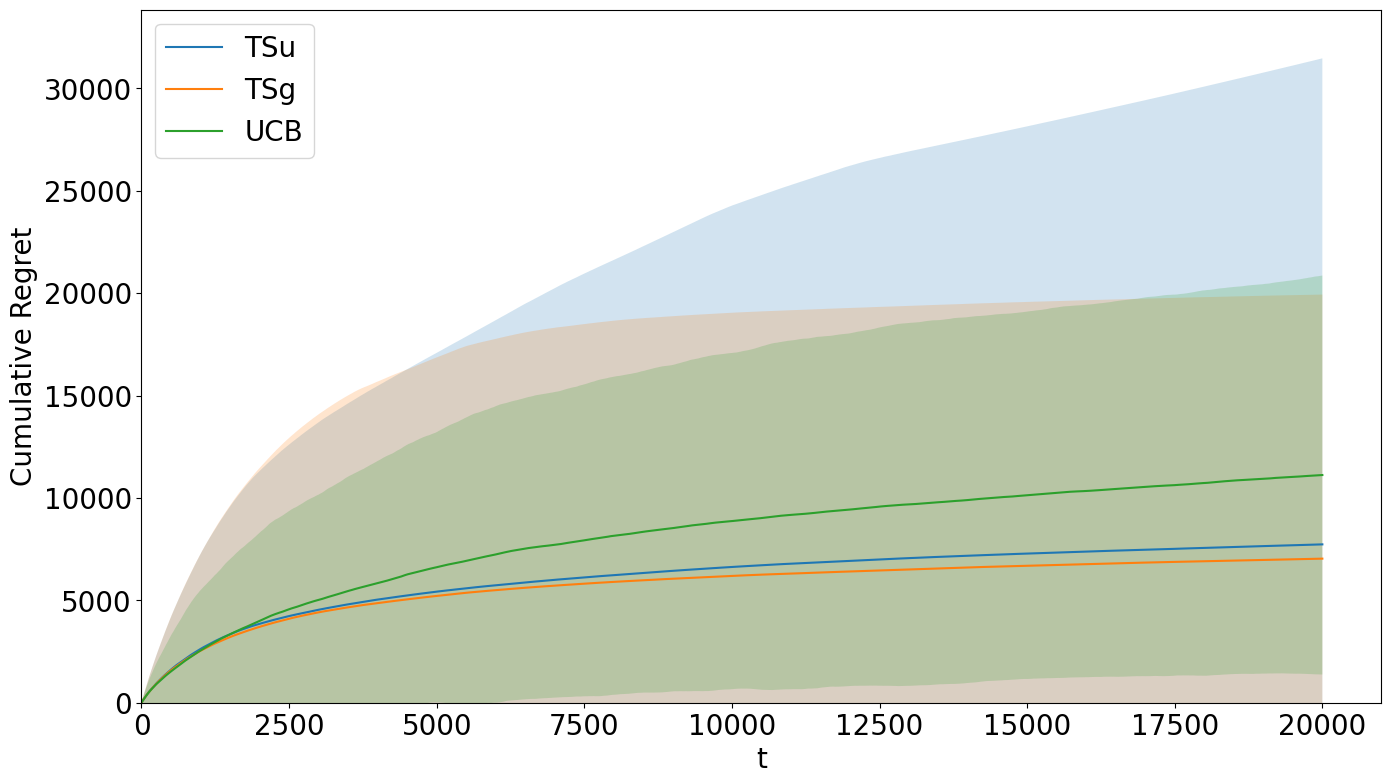

In [11]:
utilities.plot_regret(regretsdict, save = True, paramsdict = paramsdict, banditenv=problem)

# Combinatorial bandit problem

In [ ]:
from scipy.optimize import Bounds, LinearConstraint, minimize, NonlinearConstraint

In [16]:
class CombinatorialSet:
    """The class implements the basic methode of combinatorial set
    """
    def __init__(self, d, distribution, params):
        """Init the k arm bandit problem

        Args:
            d (int): number of arms
            distribution (str): distribution of rewards
            params (array): parameters of the distribution, the line i contain the parameters of the distribution of the arm i
        """

        self.d = d
        self.distribution = distribution
        self.params = params
        if distribution == 'bernoulli':
            self.mus = params
            self.sigmas = 1/2*np.ones_like(params)
        if distribution == 'gaussian':
            self.mus = params[...,0]
            self.sigmas = params[...,1]
        self.shape = self.mus.shape


    def pull(self):
        """Pull the arms
        
        Returns:
            reward (float): reward of the arms
        """

        if self.distribution == 'bernoulli':
            return np.random.binomial(1,self.mus)
        if self.distribution == 'gaussian':
            return np.random.normal(self.mus, self.sigmas)

class Twosets(CombinatorialSet):
    def __init__(self, d, distribution, params):
        super().__init__(d, distribution, params)
        assert d%2 == 0, "d must be even"
        self.name = "twosets"
        self.m=d//2

        self.bestdecision = np.argmax([np.sum(self.mus[:self.m]), np.sum(self.mus[self.m:])])
        self.bestdecisionset = np.concatenate([np.ones(self.m)*(1-self.bestdecision), np.ones(self.m)*self.bestdecision])
        self.rewardmax = np.sum(self.mus*self.bestdecisionset)
        self.Deltamin = (self.mus[self.m] - self.mus[0])*self.m

In [ ]:
bandit = Twosets(10, 'bernoulli', np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
print(bandit.m)
print(bandit.bestdecision)
print(bandit.bestdecisionset)
print(bandit.rewardmax)

In [18]:
class cbanditsAlgo:
    """This class implements the combinatorial bandit problem

    ## TODO: Make a translation table for the parameters of the algorithm
    
    attributes:

    methods:
    
    """
    def __init__(self, combinatorialset, policy, algoparams = None, prior = "uniform"):
        """

        args:
            combinatorialset: the combinatorial set to be used (Mset, matching, twosets, path )
            policy: the policy to be used (TS, TSg, UCB, egreedy, excommit)
            algoparam : the parameters of the algorithm
            prior: the prior to be used (uniform, beta, gaussian) I may put this on the algo parmeters

        Attributes:
            d (int): number of arms:
            self.muhats (array): estimated mean of the arms
            t (int): time step
            w (array): number of time an arm is played
            regrets (list) : regret at each time step
            policy (str): policy to use
            algoparams (dict): parameters of the policy.

        """

        assert combinatorialset.name == "twosets", f"Only twosets are implemented for now"

        # get the parameters of the combinatorial arm bandit problem
        self.cbandits = combinatorialset
        self.d = combinatorialset.d
        self.m = combinatorialset.m
        self.shape = combinatorialset.shape
        self.name = combinatorialset.name
        

        self.bestdecisionset = combinatorialset.bestdecisionset
        self.mus = combinatorialset.mus
        self.sigmas = combinatorialset.sigmas
        self.distribution = combinatorialset.distribution
        self.rewardmax = combinatorialset.rewardmax

        # store in the class the policy and the initial parameters
        self.policy = policy
        self.algoparams = algoparams
        self.prior = prior

        self.reset()
    
    def reset(self):
        # initialise the paramater of the algorithm
        self.regrets = []
        self.muhats = np.zeros(self.d)
        # small hack to avoid division by 0 before the arm is played for the first time
        self.t = 1
        self.w = np.ones(self.shape) * 10**(-8)

        if self.policy == 'epsilon-greedy':
            self.explore = self.algoparams["explore"]
        if self.policy == "explore-commit":
            self.explore = self.algoparams["explore"]
        if self.policy == 'cucb' or self.policy == 'escb':
            self.c = self.algoparams["c"]
        if self.policy == 'thompson-sampling':
            self.bonus = self.algoparams["bonus"]
            # self.lambd = self.algoparams["lambda"] will be added later
            self.theta = np.zeros_like(self.mus)
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    self.alphas = self.algoparams["prior"][...,0].copy()
                    self.betas = self.algoparams["prior"][...,1].copy()
                if self.prior == "uniform":
                    self.alphas = np.ones(self.shape)
                    self.betas = np.ones(self.shape)
                if self.prior == "gaussian":
                    # In the case of a gaussian prior for bernoulli distribution we assume that the prior is uniform on R
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.muhats = np.ones(self.shape)/2
                    self.sigmapost = 10**8 * np.ones(self.shape)
                if self.prior == "gaussian":
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.muhats = np.ones(self.shape)/2
                    self.sigmapost = 10**8 * np.ones(self.shape)
            if self.distribution == 'gaussian':
                if self.prior == "gaussian":
                    self.muhats = self.algoparams["prior"][...,0].copy()
                    self.sigmapost = self.algoparams["prior"][...,1].copy()
                if self.prior == "uniform":
                    self.muhats = np.zeros(self.shape)
                    self.sigmapost = 10**8 * np.ones(self.shape)
                if self.prior == "centered":
                    self.muhats = np.zeros(self.shape)
                    self.sigmapost = np.ones(self.shape)

        if self.policy == "thompson-sampling-adv":
            self.bonus = self.algoparams["bonus"]
            self.lambd = self.algoparams["lambda"]
            self.delta = self.algoparams["delta"]
            self.theta = np.zeros_like(self.mus)
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    pass
                if self.prior == "uniform":
                    pass
                if self.prior == "gaussian":
                    self.rewardsum = np.zeros(self.shape)
                    self.muhats = np.zeros(self.shape)
                    self.cov = self.lambd * np.eye(self.shape)
                    self.sigmapost = np.linalg.inv(self.cov)   
            if self.distribution == 'gaussian':
                if self.prior == "gaussian":
                    # TODO Non centered case
                    pass
                    # self.muhats = self.algoparams["prior"][...,0].copy()
                    # self.sigmapost = self.algoparams["prior"][...,1].copy()
                if self.prior == "centered":
                    self.rewardsum = np.zeros(self.shape)
                    self.muhats = np.zeros(self.shape)
                    self.covinv= self.lambd * np.eye(self.d)
                    self.covpost = np.linalg.inv(self.covinv)
    

    def select(self):
        """Select the arm to pull according to the algorithm policy
        
        Returns:
            index (int): index of the arm to pull
        """
        if self.policy == 'epsilon-greedy':
            if self.t == 1:
                if self.name == "twosets":
                    # so each decision can be played first with equal probability
                    self.bestdecision = np.random.randint(2)
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
                    return indexes
            if np.random.rand() < self.explore:
                if self.name == "twosets":
                    self.bestdecision = np.random.randint(2)
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            else:
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.muhats[:self.m]), np.sum(self.muhats[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes
        if self.policy == 'explore-commit':
            if (self.w < self.explore).any():
                if self.name == "twosets":
                    self.bestdecision = np.argmax(self.w < self.explore)
                    if self.bestdecision >= self.m:
                        self.bestdecision = 1
                    else:
                        self.bestdecision = 0
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            else:
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.muhats[:self.m]), np.sum(self.muhats[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes
        

        if self.policy == 'cucb':
            self.optimistbound = self.muhats+self.c*np.sqrt(2*np.log(self.t)/self.w)
            
            if self.name == "twosets":
                self.bestdecision = np.argmax([np.sum(self.optimistbound[:self.m]), np.sum(self.optimistbound[self.m:])])
                indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes  
        
        if self.policy == 'escb':
            # self.optimistbound = self.muhats+self.c*np.sqrt(np.log(self.t)/2/self.w)/np.sqrt(self.m) # True ESCB index
            self.optimistbound = self.muhats+self.c*np.sqrt(2*np.log(self.t)/self.w)/np.sqrt(self.m)
            if self.name == "twosets":
                self.bestdecision = np.argmax([np.sum(self.optimistbound[:self.m]), np.sum(self.optimistbound[self.m:])])
                indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes

        
        if self.policy == 'thompson-sampling':
            if (((self.prior == 'beta') or (self.prior == 'uniform')) and (self.distribution == 'bernoulli')):
                self.theta = np.random.beta(self.alphas, self.betas)
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            if (self.prior == 'gaussian' or self.prior == 'centered' or self.prior == 'uniform') and (self.distribution == 'gaussian'):
                self.theta = np.random.normal(self.muhats, self.bonus * self.sigmapost)
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes  

        if self.policy == 'thompson-sampling-adv':
            ### TODO
            # if self.prior == 'bernoulli' or self.prior == 'uniform':
            #     theta = np.random.beta(self.alphas, self.betas)
            #     if self.name == "twosets":
            #         self.bestdecision = np.argmax([np.sum(theta[:self.m]), np.sum(theta[self.m:])])
            #         indexes = np.concatenate([np.ones(self.m)*(1-self.bestdecision), np.ones(self.m)*self.bestdecision])
            if self.prior == 'gaussian' or self.prior == 'centered':
                error = 0
                for i in range(11):
                    try:
                        self.theta = np.random.multivariate_normal(self.muhats, self.bonus**2 * self.d * 9 * np.log(self.t/self.delta) * self.covpost)
                    except np.linalg.LinAlgError as e:
                        error += 1
                        if error >= 11:
                            print("error")
                    else:
                        break
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype= int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])

            return indexes
        
    def update(self, indexes, rewards):
        """Update the policy
        
        Args:
            indexes : array: indexes of the arms to pull
            rewards : list of all the rewards of ALL arm
        """
        self.t += 1
        
        if (self.w[indexes == 1] < 0.5).any():
            # correct the hack to avoid division by 0
            self.w[(indexes == 1) & (self.w < 0.5)] = 1
            self.w[(indexes == 1) & (1-(self.w < 0.5))] += 1
        else:
            self.w[indexes==1] += 1

        if self.policy == 'epsilon-greedy':
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1]
        if self.policy == 'explore-commit':
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1]

        if self.policy == "cucb":
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1]
        if self.policy == "escb":
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1]

        if self.policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == 'beta' or self.prior == 'uniform':
                    self.alphas[indexes==1] += rewards[indexes == 1]
                    self.betas[indexes==1] += 1 - rewards[indexes == 1]
                if self.prior == 'gaussian' or self.prior == 'centered':
                    sigmaprev = self.sigmapost.copy()
                    self.sigmapost[indexes==1] = np.sqrt((1/self.sigmapost[indexes==1]**2 + 1/self.sigmas[indexes == 1]**2))**-1
                    self.muhats[indexes==1] = self.sigmapost[indexes == 1]**2 * (self.muhats[indexes == 1] / sigmaprev[indexes==1]**2 + rewards[indexes == 1] / self.sigmas[indexes == 1]**2)

            if self.distribution == 'gaussian':
                sigmaprev = self.sigmapost.copy()
                self.sigmapost[indexes==1] = np.sqrt((1/self.sigmapost[indexes==1]**2 + 1/self.sigmas[indexes == 1]**2))**-1
                self.muhats[indexes==1] = self.sigmapost[indexes == 1]**2 * (self.muhats[indexes == 1] / sigmaprev[indexes==1]**2 + rewards[indexes == 1] / self.sigmas[indexes == 1]**2)
                    
        
        if self.policy == 'thompson-sampling-adv':
            ### TODO: Make it online so that we dont have to compute the inverse all the time woodbury etc
            ### TODO: implement the update for bernoulli adverserial case
            ### TODO implement the non centered case
            if self.distribution == 'bernoulli':
            #     if self.prior == 'beta' or self.prior == 'uniform':
            #         self.alphas[indexes==1] += rewards[indexes == 1]
            #         self.betas[indexes==1] += 1 - rewards[indexes == 1]
                if self.prior == 'gaussian':
                    self.rewardsum += indexes * np.sum(rewards[indexes == 1])
                    self.covinv += np.outer(indexes,indexes)
                    self.cov = np.linalg.inv(self.covinv)
                    self.muhats = self.covpost@self.rewardsum
            if self.distribution == 'gaussian':
                # TODO expend it to other cases
                    self.rewardsum += indexes * np.sum(rewards[indexes == 1])
                    self.covinv += np.outer(indexes,indexes)
                    self.covpost = np.linalg.inv(self.covinv)
                    self.muhats = self.covpost@self.rewardsum

        self.regrets.append(self.rewardmax - np.sum(self.mus[indexes==1]))



In [28]:
mat = np.random.randn(10)
print(mat)
index = np.concatenate((np.ones(5,dtype=int),np.zeros(5,dtype=int)))
select = mat[index]
print(select)




[-1.19519629e+00 -1.30120388e+00 -1.05326024e-01 -2.26606324e-01
  1.18668058e+00 -7.60405865e-04 -1.46192740e+00 -3.59935601e-02
 -9.30081923e-01  5.64792501e-01]
[-1.30120388 -1.30120388 -1.30120388 -1.30120388 -1.30120388 -1.19519629
 -1.19519629 -1.19519629 -1.19519629 -1.19519629]


In [21]:
a = np.array([[0,1] if i < d//2 else [1,1] for i in range(d)])
param = {"bonus" : 1,
         "lambda" : 1,
}
v= a[...,0]
print(v, a.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (30, 2)


## TEST the code for the combinatorial bandit problem

In [21]:
# test the code

d = 100
m = d//2
T = 100000
N = 50
# create a d arm bandit problem
problem = Twosets(d,distribution='gaussian', params=np.array([[0.9,1] if i < m else [1,1] for i in range(d)]))

# initialise the algorithms



paramsdict = {}

params = {"bonus" : 1,
         "T" : T
}

cTSu = cbanditsAlgo(problem, "thompson-sampling",algoparams =  params, prior = "uniform")
paramsdict["cTSu"] = params

# params = {"bonus" : np.sqrt(m),
#          "T" : T
# }

# cTSg = cbanditsAlgo(problem, "thompson-sampling",algoparams = params, prior = "centered")
# paramsdict["cTSg"] = params

# params = {"bonus" : np.sqrt(d/2),
#          "lambda" : 1,
#          "delta" : 1/T,
#          "T" : T
# }

# cTSadv = cbanditsAlgo(problem, "thompson-sampling-adv",algoparams = params, prior = "centered")
# paramsdict["cTSadv"] = params

params = {"c" : 1, "T" : T}
# cUCB = cbanditsAlgo(problem, "cucb", algoparams={'c' : 1})
# paramsdict["cUCB"] = params
escb = cbanditsAlgo(problem, "escb", algoparams={'c' : 1})
paramsdict["escb"] = params

# params = {"explore" : 2*(np.sqrt(d/2))/(0.1*d/2)**2/T,  "T" : T}
# egreedy = cbanditsAlgo(problem, "epsilon-greedy", algoparams=params)
# paramsdict["egreedy"] = params

# params = {"explore" : np.max([(np.sqrt(d/2)) * np.log(T*(d/2*0.1)**2/(d/2))/((d/2*0.1)**2),1])}
# excommit = cbanditsAlgo(problem, "explore-commit", algoparams=params)
# paramsdict["excommit"] = params

cTSuregrets = np.zeros((N,T))
# cTSgregrets = np.zeros((N,T))
# cTSadvregrets = np.zeros((N,T))
# cUCBregrets = np.zeros((N,T))
escbregrets = np.zeros((N,T))
# egreedyregrets = np.zeros((N,T))
# excommitregrets = np.zeros((N,T))

for k in range(N):
    print(f"iteration {k}")
    for i in range(T):

        rewards = problem.pull()

        
        indexes = cTSu.select()
        cTSu.update(indexes, rewards)

        if i > 50000:
            indexes = escb.select() # test to see if regret of escb et cTsu are the same if we use the same indexes
        escb.update(indexes, rewards)
        
        

        # indexes = cTSg.select()
        # cTSg.update(indexes, rewards)

        # indexes = cTSadv.select()
        # cTSadv.update(indexes, rewards)

        # indexes = cUCB.select()
        # cUCB.update(indexes, rewards)

        

        
        
        # indexes = egreedy.select()
        # egreedy.update(indexes, rewards)

        # indexes = excommit.select()
        # excommit.update(indexes, rewards)


    cTSuregrets[k] = cTSu.regrets.copy()
    # cTSgregrets[k] = cTSg.regrets.copy()
    # cTSadvregrets[k] = cTSadv.regrets.copy()
    # cUCBregrets[k] = cUCB.regrets.copy() 
    escbregrets[k] = escb.regrets.copy()
    # egreedyregrets[k] = egreedy.regrets.copy()
    # excommitregrets[k] = excommit.regrets.copy()

    print("cTSu regret: ", np.sum(cTSu.regrets))
    # print("cTSg regret: ", np.sum(cTSg.regrets))
    # print("cTSadv regret: ", np.sum(cTSadv.regrets))
    # print("cUCB regret: ", np.sum(cUCB.regrets))
    print("escb regret: ", np.sum(escb.regrets))
    # print("egreedy regret: ", np.sum(egreedy.regrets))
    # print("excommit regret: ", np.sum(excommit.regrets))
    cTSu.reset()
    # cTSg.reset()
    # cTSadv.reset()
    # cUCB.reset()
    escb.reset()
    # egreedy.reset()
    # excommit.reset()    

regretsdict =  {
        "cTSu" : cTSuregrets,
        #  "cTSg" : cTSgregrets,
        #  "cTSadv" : cTSadvregrets,
        #  "cUCB" : cUCBregrets,
         "escb" : escbregrets,
        #  "egreedy" : egreedyregrets,
        #  "excommit" : excommitregrets
         }

iteration 0
cTSu regret:  180.0
escb regret:  215.0
iteration 1
cTSu regret:  160.0
escb regret:  360.0
iteration 2
cTSu regret:  125.0
escb regret:  180.0
iteration 3
cTSu regret:  90.0
escb regret:  90.0
iteration 4
cTSu regret:  150.0
escb regret:  190.0
iteration 5
cTSu regret:  225.0
escb regret:  310.0
iteration 6
cTSu regret:  115.0
escb regret:  135.0
iteration 7
cTSu regret:  180.0
escb regret:  235.0
iteration 8
cTSu regret:  210.0
escb regret:  255.0
iteration 9
cTSu regret:  110.0
escb regret:  225.0
iteration 10
cTSu regret:  260.0
escb regret:  310.0
iteration 11
cTSu regret:  80.0
escb regret:  110.0
iteration 12
cTSu regret:  165.0
escb regret:  290.0
iteration 13
cTSu regret:  175.0
escb regret:  195.0
iteration 14
cTSu regret:  270.0
escb regret:  350.0
iteration 15
cTSu regret:  125.0
escb regret:  150.0
iteration 16
cTSu regret:  210.0
escb regret:  235.0
iteration 17
cTSu regret:  165.0
escb regret:  350.0
iteration 18
cTSu regret:  180.0
escb regret:  285.0
iterat

In [ ]:
#  Creating a test function to test the algorithms

def testalgo(algos, paramsdict, problem, T, N):
    pass

In [ ]:
#  Testing algorithms with multiple cores

In [ ]:
# print(cTSadv.bonus)
# print(cTSadv.sigmapost)

In [16]:
import importlib
importlib.reload(utilities)

<module 'utilities' from '/home/zhang/Bureau/cbandits/utilities.py'>

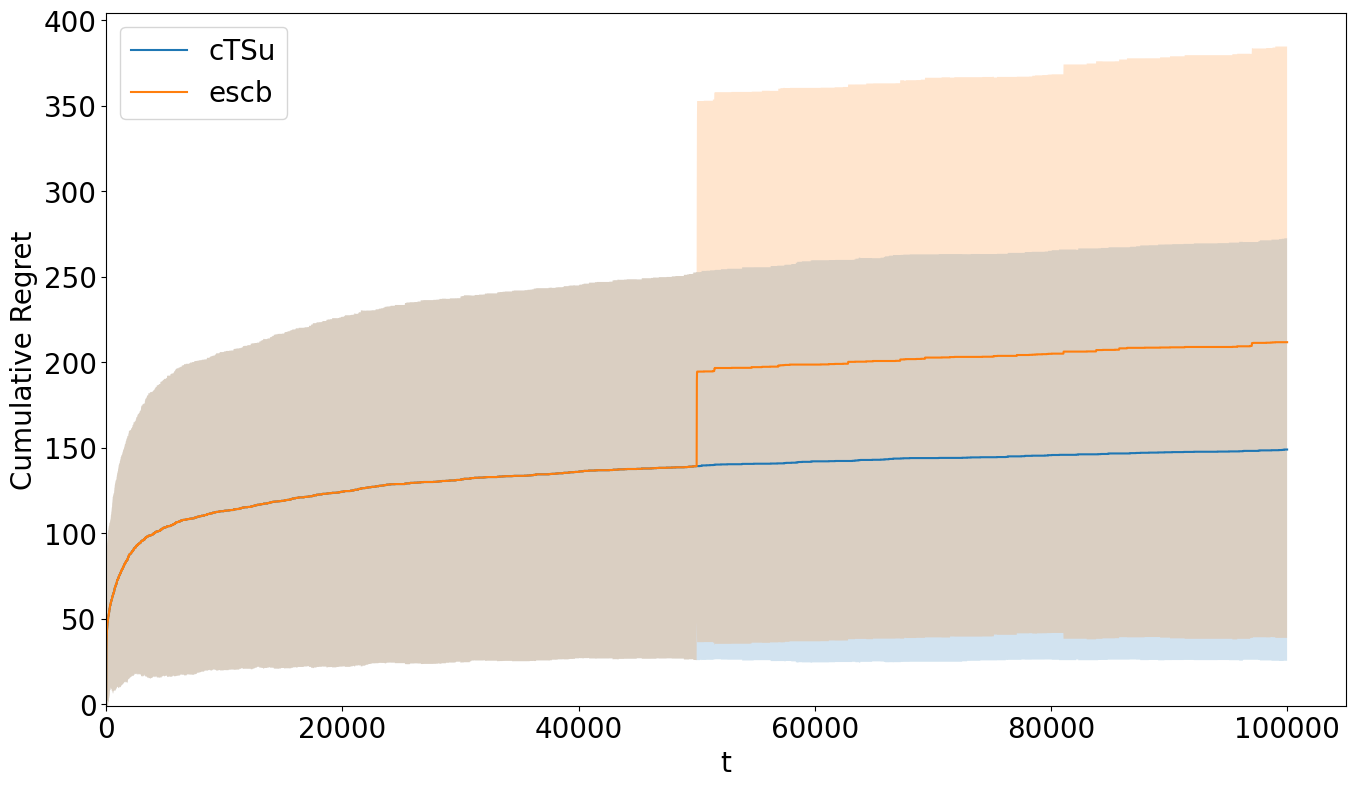

In [20]:
utilities.plot_regret(regretsdict, save = False, paramsdict = paramsdict, banditenv = problem, mode = 1)

In [12]:
nruns = 10**3
T = 10**5
superrun = 100
nproc = 10

In [13]:
def hittime(nruns, T, superrun, variables):
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    meanTS = 0
    meanESCB = 0
    logt = np.sqrt(2*np.log(np.arange(1,T+1)))

    for i in range(superrun):
        muhats = np.random.randn(nruns)
        thetas = muhats +  1.01*np.random.randn(T, nruns)
        Thitescb = muhats <= logt.reshape(-1,1)
        Thitescb[-1,] = np.ones_like(Thitescb[-1,])
        Thitescb = np.argmax(Thitescb, axis = 0)
        
        ThitTS = thetas >= 0
        ThitTS[-1,:] = np.ones_like(ThitTS[-1,:])
        
        ThitTS= np.argmax(thetas >= 0 , axis = 0)

        meanTS += np.mean(ThitTS)/superrun
        meanESCB += np.mean(Thitescb)/superrun

    variables[0].value += meanTS
    variables[1].value += meanESCB

In [14]:
logt = np.sqrt(np.log(np.arange(1,T+1))/2)


In [15]:
meanTS = Value("f", 0)
meanESCB = Value("f", 0) 

variables = [meanTS, meanESCB]
processes = [Process(target=hittime, args=(nruns, T, superrun, variables)) for i in range(nproc)]

for process in processes:
    process.start()
    # wait for all processes to complete
for process in processes:
    process.join()
# report that all tasks are completed
print(f"TS hitting time : {variables[0].value/nproc},\n ESCB hitting time : {variables[1].value/nproc}", flush=True)

TS hitting time : 9.576251220703124,
 ESCB hitting time : 1.9206781387329102


In [80]:
logt = np.sqrt(np.log(np.arange(1,T+1))/2)
muhats = np.random.randn(nruns)
Thitescb = muhats <= logt.reshape(-1,1)
Thitescb[-1,] = np.ones_like(Thitescb[-1,:])
Thitescb = np.argmax(Thitescb, axis = 0)

print(np.mean(Thitescb))

46.53247


In [81]:
print(np.max(muhats))
print(np.max(Thitescb))
print(np.argmax(muhats))

4.836584992293411
999
83500


In [77]:
(muhats <= logt.reshape(-1,1))[:,81968]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [68]:
np.maximum(muhats, 0)

array([1.24715696, 1.37180928, 0.        , ..., 0.07971027, 1.29834909,
       0.        ])